**Using Optuna for hyperparameter tuning and then selecting the best architecture for further methods and processing**

In [1]:
#Library import 
!pip3 install optuna
!pip3 install gdown
import optuna
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np 
np.random.RandomState(seed=42)
!gdown --id 1lUZssANz3BVri3pef2Hxz1XAnlvushrA

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:130: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From (uriginal): https://drive.google.com/uc?id=1lUZssANz3BVri3pef2Hxz1XAnlvushrA
From (redirected): https://drive.google.com/uc?id=1lUZssANz3BVri3pef2Hxz1XAnlvushrA&confirm=t&uuid=a649ab4e-897d-4201-ab02-be8fa2deb4ad
To: /kaggle/working/dataset.npy
100%|███████████████████████████████████████| 1.79G/1.79G [00:09<00:00, 189MB/s]


In [2]:

# Load dataset
data = np.load('/kaggle/working/dataset.npy', allow_pickle = True)
data.shape

(11446, 2)

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

In [3]:

#creating features and target variables 
X=[]#features 
Y=[]#target
for x in range(data.shape[0]):
    if data[x][1]==1 or data[x][1]==2 or data[x][1]==3:
        X.append(data[x][0])
        Y.append(data[x][1])
#Creating target variable as sparse 
from sklearn.preprocessing import OneHotEncoder
y=np.array(Y).reshape(-1,1)
encoder = OneHotEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y).toarray()

print("Sample of X: ",X[0])
print("Sample of Y: ",y_encoded[0])


Sample of X:  [[[ 79 108 117]
  [ 70  99 109]
  [ 87 116 129]
  ...
  [110 132 186]
  [107 129 183]
  [ 99 120 175]]

 [[ 74  98 124]
  [ 90 114 141]
  [101 125 152]
  ...
  [ 97 118 169]
  [101 122 174]
  [ 98 119 170]]

 [[ 86 110 135]
  [ 87 112 137]
  [ 82 106 133]
  ...
  [ 93 112 159]
  [ 82 100 148]
  [ 69  86 134]]

 ...

 [[120 135 173]
  [119 134 172]
  [118 133 171]
  ...
  [111 129 179]
  [109 127 177]
  [105 123 173]]

 [[119 134 172]
  [118 133 171]
  [119 134 172]
  ...
  [111 129 179]
  [106 124 174]
  [109 127 177]]

 [[119 132 173]
  [118 132 172]
  [122 135 178]
  ...
  [116 134 184]
  [113 131 181]
  [117 135 185]]]
Sample of Y:  [0. 1. 0.]


In [4]:

#splitting the dataset
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(np.array(X),y_encoded,test_size=0.2,random_state=42)
#normalizing the pixel values 
x_train=x_train/255.0
x_test=x_test/255.0


In [5]:
print("Shape of X Train data is : ",x_train.shape,"\n************")
print("Shape of Y Train data is : ",y_train.shape,"\n************")
print("Shape of X test data is : ",x_test.shape,"\n************")
print("Shape of Y test data is : ",y_test.shape,"\n************")

Shape of X Train data is :  (1191, 228, 228, 3) 
************
Shape of Y Train data is :  (1191, 3) 
************
Shape of X test data is :  (298, 228, 228, 3) 
************
Shape of Y test data is :  (298, 3) 
************


In [6]:

# Define CNN model architecture
# with strategy.scope(): 
def create_model(trial):      
            learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
            num_layers = trial.suggest_int("num_layers", 1, 5)
            activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
            model = Sequential()
            model.add(Conv2D(
                filters=trial.suggest_int("filters", 32, 128),
                kernel_size=trial.suggest_int("kernel_size", 3, 5),
                padding="same",
                activation=activation,
                input_shape=(228, 228, 3)
            ))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(Dropout(rate=trial.suggest_float("dropout_rate", 0.1, 0.5)))
            model.add(Conv2D(
                    filters=trial.suggest_int("filters", 32, 128),
                    kernel_size=trial.suggest_int("kernel_size", 3, 5),
                    padding="same",
                    activation=activation
                ))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(Dropout(rate=trial.suggest_float("dropout_rate", 0.1, 0.5)))
            model.add(Flatten())
            for i in range(num_layers):
                  model.add(Dense(
                      units=trial.suggest_int("units", 64, 1024),
                      activation=activation
                  ))
            model.add(Dropout(rate=trial.suggest_float("dropout_rate", 0.1, 0.5)))
            model.add(Dense(units=3, activation="softmax"))
            model.compile(optimizer=Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])
            return model


In [7]:

# Define objective function for Optuna to optimize
def objective(trial):

    model = create_model(trial)
    history=model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32, verbose=0)
    # accuracy = model.evaluate(x_test, y_test, verbose=0)[1]
    val_acc = history.history['val_accuracy'][-1]
    return val_acc


In [8]:

# Run Optuna optimization
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize",sampler=sampler)
study.optimize(objective, n_trials=4)


[I 2023-04-06 16:05:11,447] A new study created in memory with name: no-name-403b95b1-1ba7-4098-ae93-c246b7eb8bc9
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
2023-04-06 16:05:18.919286: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
[I 2023-04-06 16:06:40,981] Trial 0 finished with value: 0.6845637559890747 and parameters: {'learning_rate': 0.0001329291894316216, 'num_layers': 5, 'activation': 'relu', 'filters': 47, 'kernel_size': 3, 'dropout_rate': 0.4464704583099741, 'units': 641}. Best is trial 0 with value: 0.684563755989

In [9]:

# Print best hyperparameters and accuracy
best_trial = study.best_trial
print(f"Best hyperparameters: {best_trial.params}")
print(f"Best accuracy: {best_trial.value}")


Best hyperparameters: {'learning_rate': 0.0001329291894316216, 'num_layers': 5, 'activation': 'relu', 'filters': 47, 'kernel_size': 3, 'dropout_rate': 0.4464704583099741, 'units': 641}
Best accuracy: 0.6845637559890747


In [13]:
#plot parameter relationship as a contour plot
fig = optuna.visualization.plot_contour(study, params=["num_layers", "filters","kernel_size","learning_rate","activation","dropout_rate"])
fig.update_layout(
    margin=dict(l=30, r=30, t=30, b=30),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

In [15]:
#importance of parameter 
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [17]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

**Based on the above architecture and their optimum values we decide the final architecture and use it for further processing**

In [19]:
model = Sequential()
model.add(Conv2D(
                filters=47,
                kernel_size=3,
                padding="same",
                activation="relu",
                input_shape=(228, 228, 3)
            ))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.4464704583099741))
model.add(Conv2D(
                filters=47,
                kernel_size=3,
                padding="same",
                activation="relu"
                ))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.4464704583099741))
model.add(Flatten())
model.add(Dense(units=641,activation="relu"))
model.add(Dense(units=641,activation="relu"))
model.add(Dense(units=641,activation="relu"))
model.add(Dense(units=641,activation="relu"))
model.add(Dense(units=641,activation="relu"))
model.add(Dropout(rate=0.4464704583099741))
model.add(Dense(units=3, activation="softmax"))
model.compile(optimizer=Adam(learning_rate=0.0001329291894316216), loss="categorical_crossentropy", metrics=["accuracy"])

In [20]:
history=model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=0)

2023-04-06 16:30:23.258754: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


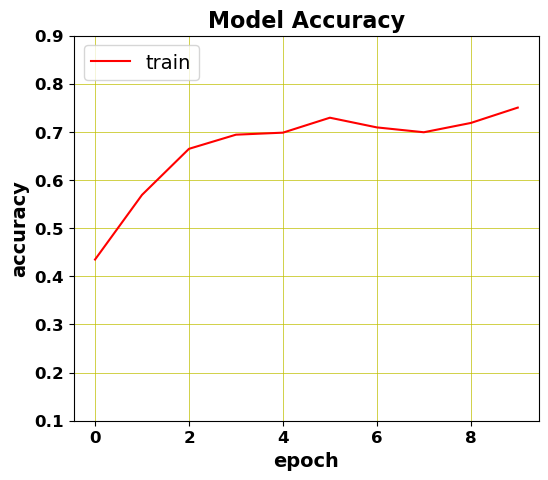

In [23]:
import matplotlib.pyplot as plt 
%matplotlib inline
plt.figure(figsize=(6, 5))
plt.plot(history.history['accuracy'], color='r')
plt.title('Model Accuracy', weight='bold', fontsize=16)
plt.ylabel('accuracy', weight='bold', fontsize=14)
plt.xlabel('epoch', weight='bold', fontsize=14)
plt.ylim(0.1, 0.9)
plt.xticks(weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=12)
plt.legend(['train'], loc='upper left', prop={'size': 14})
plt.grid(color = 'y', linewidth='0.5')
plt.show()

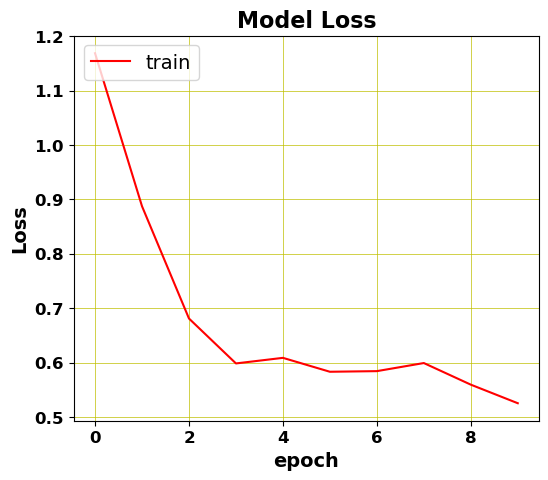

In [24]:
plt.figure(figsize=(6, 5))
plt.plot(history.history['loss'], color='r')
plt.title('Model Loss', weight='bold', fontsize=16)
plt.ylabel('Loss', weight='bold', fontsize=14)
plt.xlabel('epoch', weight='bold', fontsize=14)
# plt.ylim(0.1, 0.9)
plt.xticks(weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=12)
plt.legend(['train'], loc='upper left', prop={'size': 14})
plt.grid(color = 'y', linewidth='0.5')
plt.show()

In [26]:
eval=model.evaluate(x_test,y_test)
print("Accuracy of the model is : ",eval[1]*100)
print("Loss of the model is : ",eval[0]*100)

10/10 [==============================] - 0s 28ms/step - loss: 1.0254 - accuracy: 0.4631
Accuracy of the model is :  46.3087260723114
Loss of the model is :  102.54232883453369


**Using model to extract features and put it inot machine learning model.**

In [31]:
x_train_features = model.predict(x_train)
x_test_features = model.predict(x_test)

# Flatten features
x_train_features = x_train_features.reshape(x_train.shape[0], -1)
x_test_features = x_test_features.reshape(x_test.shape[0], -1)

# Train random forest classifier on features
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier(n_estimators=100, max_depth=20,random_state=42)
rf.fit(x_train_features, y_train)
y_pred = rf.predict(x_test_features)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100}")

10/10 [==============================] - 0s 19ms/step
Accuracy: 71.14093959731544


**Testing Multiple Classifiers**